# Image Reconstruction Using Poutyne

In this example, we train a simple convolutional autoencoder (Conv-AE) on the MNIST dataset to learn image reconstruction. The Conv-AE is composed of two parts: an encoder and a decoder. The encoder encodes the input images to extract compact image features. The decoder, on the other hand, decodes the extracted features to reconstruct the input images.

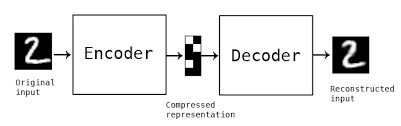


[Source](https://blog.keras.io/building-autoencoders-in-keras.html)

In [ ]:
%pip install poutyne

Let’s import all the needed packages.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid

## Training Constants

In [2]:
num_epochs = 3
learning_rate = 0.001
batch_size = 32
image_size = 224
valid_split_percent = 0.2
momentum = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device)
set_seeds(42)

The running processor is... cuda


## Loading the MNIST Dataset

The MNIST dataset is directly downloaded from the `torchvision.datasets` package. The training dataset contains 60,000 images of digits of size 28x28. However, we separate 20% of the full train dataset as a validation dataset. Also, by setting the `train` argument to `False`, the test dataset containing 10,000 images is downloaded and saved in the "datasets" directory.

In [3]:
full_train_dataset = datasets.MNIST('./datasets/', train=True, download=True, transform=tfms.ToTensor())
test_dataset = datasets.MNIST('./datasets/', train=False, download=True, transform=tfms.ToTensor())

# Selecting and seperating a proportion of the full_train_dataset to create the validation dataset.
full_dataset_length = len(full_train_dataset)
indices = list(np.arange(full_dataset_length))
np.random.shuffle(indices)
train_indices = indices[math.floor(full_dataset_length * valid_split_percent):]
valid_indices = indices[:math.floor(full_dataset_length * valid_split_percent)]

train_dataset = Subset(full_train_dataset, train_indices)
valid_dataset = Subset(full_train_dataset, valid_indices)

The downloaded MNIST dataset format is for classification, which means each sample contains an image and a label (the digit drawn in the image). However, for image reconstruction, the dataset should contain an input image and a target image, which are simply the same. Hence, using the code below, we define a new dataset that wraps an MNIST dataset and provides an image as an input and sets that image as its target. In other words, we change the format of each dataset sample from (image, label) to the (image, image).

In [4]:
class ImageReconstructionDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset
          
    def __getitem__(self, index):
        input_image = self.dataset[index][0]
        target_image = input_image  # In image reconstruction, input and target images are the same.
          
        return input_image, target_image
      
    def __len__(self):
        return len(self.dataset)   

Finally, in the section below, we wrap the MNIST datasets into our wrapper and create data loaders for them.

In [5]:
train_dataset_new = ImageReconstructionDataset(train_dataset)
valid_dataset_new = ImageReconstructionDataset(valid_dataset)
test_dataset_new = ImageReconstructionDataset(test_dataset)

train_dataloader = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset_new, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

## Convolutional Autoencoder

The most frequently used network for image reconstruction is the autoencoder. In this section, we are going to define our own autoencoder. The encoder section tries to encode the input image into features and consequently, the decoder tries to decode the features and reconstruct the original image. As our input dataset (MNIST) contains images with low resolution and low complexity, we preferred not to design a complex network in order to avoid overfitting.

In [6]:
class ConvAutoencoder(nn.Module):

    def __init__(self):
        super(ConvAutoencoder, self).__init__()
      
        #encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
      
        #decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        x = torch.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
              
        return x

network = ConvAutoencoder()
print(network)

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In order to interact with the optimization process, <a href="https://poutyne.org/callbacks.html"> callbacks</a> are defined and added to a list using the code below. They will save the last weights, best weights and the logs, respectively.

In [7]:
save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                    save_best_only=True, verbose=True),

    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

Let's specify the loss and the optimization function.

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

## Training

In [9]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(train_dataloader, valid_dataloader, epochs=num_epochs, callbacks=callbacks)

Epoch: 1/3 Train steps: 1500 Val steps: 375 9.59s loss: 0.034685 val_loss: 0.016441
Epoch 1: val_loss improved from inf to 0.01644, saving file to saves/best_weight.ckpt
Epoch: 2/3 Train steps: 1500 Val steps: 375 9.39s loss: 0.015048 val_loss: 0.014117
Epoch 2: val_loss improved from 0.01644 to 0.01412, saving file to saves/best_weight.ckpt
Epoch: 3/3 Train steps: 1500 Val steps: 375 10.07s loss: 0.013613 val_loss: 0.013223
Epoch 3: val_loss improved from 0.01412 to 0.01322, saving file to saves/best_weight.ckpt


[{'epoch': 1,
  'loss': 0.03468461787328124,
  'time': 9.589070166926831,
  'val_loss': 0.016440646742781003},
 {'epoch': 2,
  'loss': 0.015048056442290545,
  'time': 9.392800391186029,
  'val_loss': 0.014116948055724303},
 {'epoch': 3,
  'loss': 0.013612905304258068,
  'time': 10.06593153718859,
  'val_loss': 0.01322274027019739}]

## A Random Batch of the MNIST Dataset Images

Let's see some of the input samples inside the training dataset.

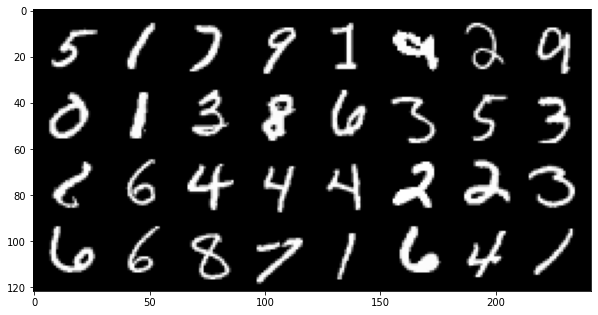

In [10]:
inputs = next(iter(train_dataloader))[0]
input_grid = make_grid(inputs)
fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

## Reconstructed Images after 3 Epochs of Training

Here, we show the reconstruction results of the samples shown above to visually evaluate the quality of the results.

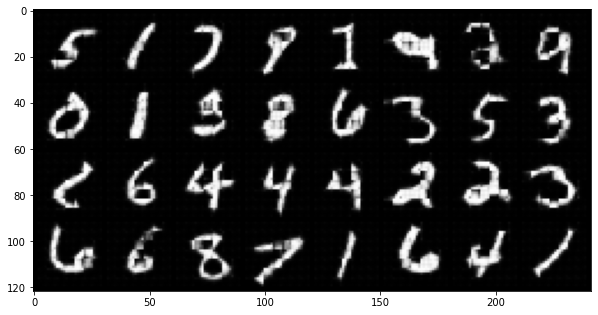

In [11]:
# Calculating predictions of the trained network on a batch
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

## Evaluation

One of the useful tools of Poutyne is the `evaluate` methods, which provide you with the evaluation metrics and the ground truths and the predictions if the related arguments have been set to True (as below).

In [12]:
# evaluating the trained network on test data
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 14.06s test_loss: 0.012831                                                   


In most computer vision applications, such as image reconstruction, it is imperative to check the network's failures (or abilities, vice versa). The following part shows an example of an input and the reconstructed image, as well as its reconstruction error map. The reconstruction error map shows which part of the image has not been reconstructed accurately.

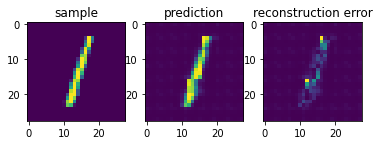

In [13]:
sample_number = 2   # a sample from test dataset

sample = ground_truth[sample_number][0]
sample_prediction_result_3epochs = predictions[sample_number][0]

recunstruction_error_map_3epochs = sample - sample_prediction_result_3epochs  #reconstruction error map
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(sample)
ax1.set_title('sample')

ax2.imshow(sample_prediction_result_3epochs)
ax2.set_title('prediction')

ax3.imshow(np.abs(recunstruction_error_map_3epochs))
ax3.set_title('reconstruction error')
plt.show()

## Resuming the training for more epochs

If we find the previous epochs' results not enough, Poutyne allows you to resume the last done epoch's training, as shown below. Please note that in the `callbacks` that we defined before since we did not set the `restore_best` argument in `ModelCheckpoint` to `True`, our model stays at the last epoch after finishing the first part of the training. Hence, by setting the `initial_epoch + 1` to the last epoch of the previous training, we can resume our training to train for more epochs, using the last state of the neural network.

In [14]:
model.fit_generator(train_dataloader, valid_dataloader, epochs=13, callbacks=callbacks, initial_epoch=num_epochs + 1)

Epoch:  4/13 Train steps: 1500 Val steps: 375 10.10s loss: 0.012895 val_loss: 0.012652
Epoch 4: val_loss improved from 0.01322 to 0.01265, saving file to saves/best_weight.ckpt
Epoch:  5/13 Train steps: 1500 Val steps: 375 10.14s loss: 0.012395 val_loss: 0.012184
Epoch 5: val_loss improved from 0.01265 to 0.01218, saving file to saves/best_weight.ckpt
Epoch:  6/13 Train steps: 1500 Val steps: 375 10.07s loss: 0.011956 val_loss: 0.011757
Epoch 6: val_loss improved from 0.01218 to 0.01176, saving file to saves/best_weight.ckpt
Epoch:  7/13 Train steps: 1500 Val steps: 375 9.53s loss: 0.011606 val_loss: 0.011468
Epoch 7: val_loss improved from 0.01176 to 0.01147, saving file to saves/best_weight.ckpt
Epoch:  8/13 Train steps: 1500 Val steps: 375 9.94s loss: 0.011356 val_loss: 0.011269
Epoch 8: val_loss improved from 0.01147 to 0.01127, saving file to saves/best_weight.ckpt
Epoch:  9/13 Train steps: 1500 Val steps: 375 9.67s loss: 0.011153 val_loss: 0.011040
Epoch 9: val_loss improved from

[{'epoch': 4,
  'loss': 0.012894643122330308,
  'time': 10.103995468001813,
  'val_loss': 0.012651992119848729},
 {'epoch': 5,
  'loss': 0.01239460095949471,
  'time': 10.141955567058176,
  'val_loss': 0.012184420389433702},
 {'epoch': 6,
  'loss': 0.0119562498498708,
  'time': 10.073587308637798,
  'val_loss': 0.011756646285454432},
 {'epoch': 7,
  'loss': 0.011606481107572715,
  'time': 9.52735163224861,
  'val_loss': 0.011468143661816916},
 {'epoch': 8,
  'loss': 0.0113561878533413,
  'time': 9.942390580195934,
  'val_loss': 0.011269237622618675},
 {'epoch': 9,
  'loss': 0.011152683472881715,
  'time': 9.674667735118419,
  'val_loss': 0.01104043193658193},
 {'epoch': 10,
  'loss': 0.010972419874432187,
  'time': 10.008274586405605,
  'val_loss': 0.010895797359446685},
 {'epoch': 11,
  'loss': 0.010830769306669633,
  'time': 9.84986284095794,
  'val_loss': 0.010776704773306847},
 {'epoch': 12,
  'loss': 0.010717504305765032,
  'time': 9.493937500752509,
  'val_loss': 0.01070831336826

## Reconstructed images after the second training process

Now let's visualize the quality of the results after the second training.

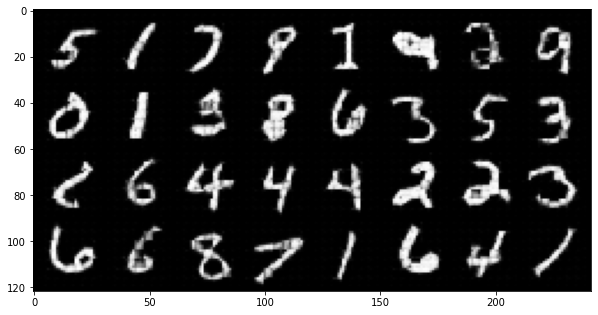

In [15]:
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

In [16]:
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 10000 13.99s test_loss: 0.010305                                                   


Here, we compare the reconstruction accuracy of the network after 3 epochs and 13 epochs of training.

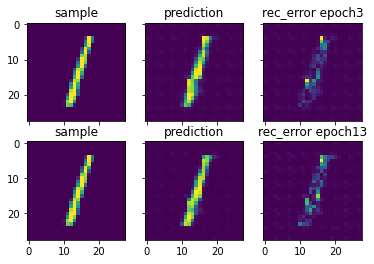

In [17]:
sample_number = 2 
sample = ground_truth[sample_number][0]
sample_prediction_result_13epochs = predictions[sample_number][0]
recunstruction_error_map_13epochs = sample - sample_prediction_result_13epochs  #reconstruction error map

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
axs[0, 0].imshow(sample)
axs[0, 0].set_title('sample')

axs[0, 1].imshow(sample_prediction_result_3epochs)
axs[0, 1].set_title('prediction')

axs[0, 2].imshow(np.abs(recunstruction_error_map_3epochs))
axs[0, 2].set_title('rec_error epoch3')

axs[1, 0].imshow(sample)
axs[1, 0].set_title('sample')

axs[1, 1].imshow(sample_prediction_result_13epochs)
axs[1, 1].set_title('prediction')

axs[1, 2].imshow(np.abs(recunstruction_error_map_13epochs))
axs[1, 2].set_title('rec_error epoch13')

plt.show()

You can also try finetuning the model to obtain better performance. Such as changing the hyperparameters (network capacity, epochs, etc.).